In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint

import torch
import pickle
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt

from utils import utils
import deformation.losses as def_losses
from deformation.semantic_discriminator_loss import SemanticDiscriminatorLoss 
from semantic_discriminator_trainer import train
from deformation.semantic_discriminator_dataset import SemanticDiscriminatorDataset

In [4]:
gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))

#mesh_path = "data/test_dataset/0001old.obj"
mesh_path = "data/test_dataset_one_processed/batch_1_of_1/0001old.obj"
with torch.no_grad():
    mesh = utils.load_untextured_mesh(mesh_path, device)

cfg_path = "configs/testing.yaml"
cfg = utils.load_config(cfg_path,"configs/default.yaml")
pprint.pprint(cfg)

{'brute_force_pose_est': {'num_azims': 20, 'num_dists': 40, 'num_elevs': 20},
 'dataset': {'input_dir_img': 'data/test_dataset_one',
             'input_dir_mesh': 'data/test_dataset_one'},
 'model': {'latent_dim_pointnet': 512, 'latent_dim_resnet': 256},
 'semantic_dis_training': {'epochs': 10,
                           'eval_every': 1,
                           'fake_dataset_dir': 'data/semantic_dis_sil/fake_renders',
                           'output_dir': 'out',
                           'real_dataset_dir': 'data/semantic_dis_sil/real_renders'},
 'training': {'img_sym_lam': 100,
              'img_sym_num_azim': 1,
              'l2_lam': 1,
              'lap_lam': 10,
              'learning_rate': 1e-05,
              'normals_lam': 10,
              'num_iterations': 600,
              'semantic_dis_lam': 100,
              'semantic_dis_num_render': 8,
              'semantic_dis_weight_path': 'out/2020_08_24--06_45_44_dcgan_dis_drop8/weights_epoch_3.pt',
              'si

/home/svcl-oowl/brandon/research/sil_consistent_at_inference/utils/utils.py:52: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg_special = yaml.load(f)
/home/svcl-oowl/brandon/research/sil_consistent_at_inference/utils/utils.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(f)


# Image Symmetry Loss

In [ ]:
sym_plane_normal = [0,0,1]
num_azim = 1
render_sil = False
img_sym_loss, sym_triples = def_losses.image_symmetry_loss(mesh, sym_plane_normal, num_azim, device, render_sil)
print(img_sym_loss)

In [ ]:
img_names = {0:'R1', 1:'R1_flipped', 2:'R2'}
for trip_idx, sym_triple in enumerate(sym_triples):
    fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=False)
    for i in range(3):
        if render_sil:
            ax[0][i].imshow(sym_triple[i].cpu().numpy())
        else:
            ax[0][i].imshow(sym_triple[i][ ..., :3].cpu().numpy())
        ax[0][i].xaxis.set_visible(False)
        ax[0][i].yaxis.set_visible(False)
        
        ax[0][i].set_title("{}: {}".format(trip_idx, img_names[i]))

# Semantic Discriminator Training

In [35]:
dataset = SemanticDiscriminatorDataset(cfg, "train")
print(len(dataset))

22992


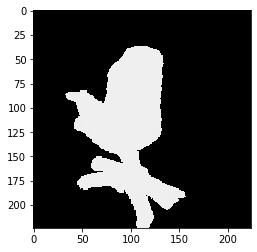

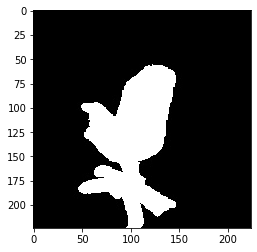

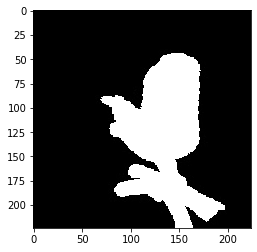

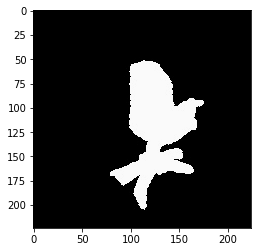

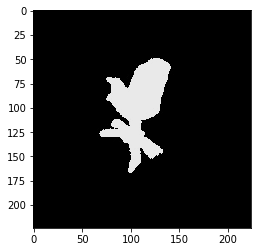

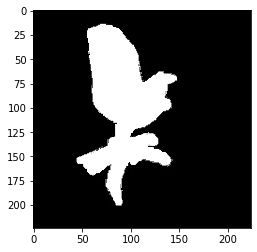

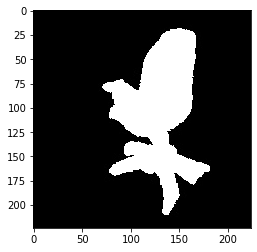

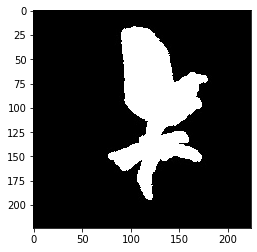

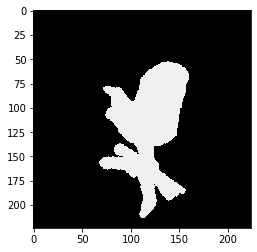

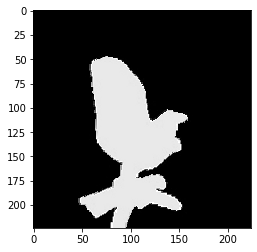

In [46]:
img_i = 95
for i in range(10):
    data_real = dataset[img_i]['fake']
    plt.imshow(data_real.permute(1,2,0))
    plt.show()

In [ ]:



data_real = dataset[i]['real']
plt.imshow(data_real.permute(1,2,0))
plt.show()
data_fake = dataset[i]['fake']
plt.imshow(data_fake.permute(1,2,0))
plt.show()

In [ ]:
df_dict = train(cfg_path, gpu_num)

In [ ]:
df_dict['train'].plot.line(x='iteration', y='train_loss')
df_dict['val'].plot.line(x='epoch', y='val_acc')

# Semantic Discriminator Loss

In [7]:
cfg = utils.load_config(cfg_path,"configs/default.yaml")
with torch.no_grad():
    mesh = utils.load_untextured_mesh(mesh_path, device)
semantic_loss_computer = SemanticDiscriminatorLoss(cfg, device)
semantic_dis_loss, semantic_loss_renders = semantic_loss_computer.compute_loss(mesh)
print(semantic_dis_loss.item())

0.2436242699623108


torch.Size([8, 224, 224, 3])


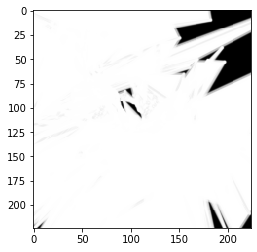

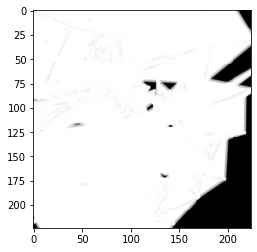

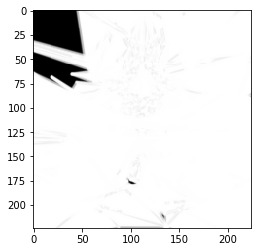

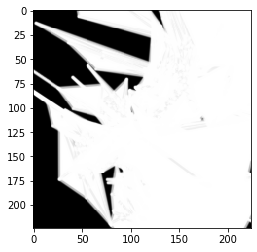

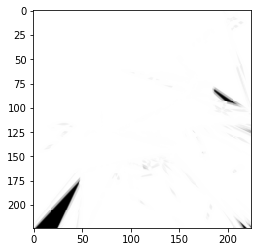

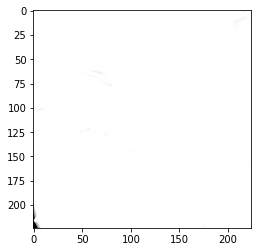

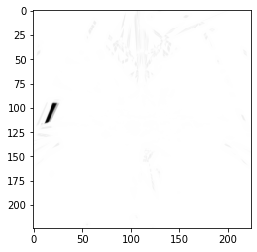

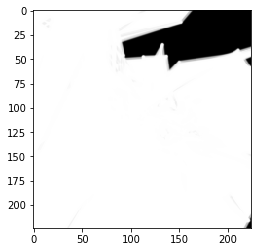

In [8]:
print(semantic_loss_renders.shape)
for render in semantic_loss_renders:
    plt.imshow(render.cpu().numpy())
    plt.show()

# Semantic Embedding Loss

In [ ]:
weights_path = "data/occnet_pretrained_weights/model_best.pt"
cfg_yaml_path = "occ_uda/configs/domain_adaptation/chair_noDA.yaml"
emb_path = "occ_uda/chair_noDA_train_latent_vecs.p"
emb_loss = def_losses.SemanticEmbeddingLoss(cfg_yaml_path, weights_path, emb_path, device)
loss, renderr = emb_loss.compute_loss(mesh)